In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [117]:
class PhotonGas:
    def __init__(self, be, n_init, mc_steps, eqm_steps=None):
        self.rng = np.random.default_rng()
        self.be = be
        self.configs = {}
        self.n_old = n_init
        self.n_new = None
        self.n_steps = mc_steps
        self.istep = 0
        if (eqm_steps is None):
            self.eqm_steps = int(mc_steps*0.8)
        else:
            self.eqm_steps = int(eqm_steps)
        self.equilibrated = False
        
        self.U = self.get_U(self.n_old)
        self.U_traj = np.zeros(mc_steps)
        self.U_traj[self.istep] = self.U
        self.n_traj = np.zeros(mc_steps)
        self.n_traj[self.istep] = self.n_old
    
    def get_U(self, n):
        return self.be*n
    
    def decide_accept(self):
        u_new = self.get_U(self.n_new)
        u_old = self.get_U(self.n_old)
        if u_new <= u_old:
            # accept
            self.do_accept(u_new)
        else:
            # conditional acceptance
            rand = self.rng.uniform()
            if (np.exp(-(u_new-u_old)) > rand):
                self.do_accept(u_new)
            else:
                if (self.equilibrated):
                    if self.n_old in self.configs.keys():
                        self.configs[self.n_old] += 1
                    else:
                        self.configs[self.n_old] = 1
                self.U = u_old
            
    def do_accept(self, u_new):
        self.n_old = self.n_new
        self.U = u_new
        if (self.equilibrated):
            if self.n_new in self.configs.keys():
                self.configs[self.n_new] += 1
            else:
                self.configs[self.n_new] = 1
        
    def do_mc_steps(self):
        while self.istep < self.n_steps-1:
            self.istep += 1
            if (self.istep >= self.eqm_steps):
                self.equilibrated = True
            self.generate_trial_move()
            self.decide_accept()
            self.U_traj[self.istep] = self.U
            self.n_traj[self.istep] = self.n_old
            
        self.mc_avg = np.average(self.n_traj[self.eqm_steps:])
        self.theo_avg = 1.0/(np.exp(self.be)-1)
        
    def generate_trial_move(self):
        rand = self.rng.uniform()
        
        if (rand >= 0.5):
            self.n_new = self.n_old + 1
        else:
            self.n_new = self.n_old - 1
            
        if self.n_new < 0:
            self.n_new = 0
            
    def plot_mc_traj(self):
        f, ax = plt.subplots(figsize=(12,6))
        ax.plot(self.n_traj[:])
        ax.axhline(self.mc_avg, linestyle='--', c='tab:orange', label=r'$\langle N \rangle_{{\mathrm{{MC}}}}={mc_avg:.4f}$'.format(mc_avg=self.mc_avg))
        ax.axhline(self.theo_avg ,linestyle='--', c='tab:green', label=r'$\langle N \rangle_{{\mathrm{{Theo.}}}}={theo_avg:.4f}$'.format(theo_avg=self.theo_avg))
        ax.axvline(self.eqm_steps, linestyle='--', linewidth=1, c='k',label='Equilibration point')
        axins = ax.inset_axes([0.3,0.7,0.6,0.25])
        axins.plot(self.n_traj)
        axins.set_xlim([self.eqm_steps,self.n_steps])
        axins.axhline(self.mc_avg, linestyle='--', c='tab:orange', label=r'$\langle N \rangle_{{\mathrm{{MC}}}}={mc_avg:.4f}$'.format(mc_avg=self.mc_avg))
        axins.axhline(self.theo_avg ,linestyle='--', c='tab:green', label=r'$\langle N \rangle_{{\mathrm{{Theo.}}}}={theo_avg:.4f}$'.format(theo_avg=self.theo_avg))
        axins.set_ylim([self.mc_avg*0.8, self.mc_avg*1.2])
        ax.legend()
        ax.set_xlabel('MC iteration')
        ax.set_ylabel(r'$N_{{\mathrm{{phot.}}}}$')
        ax.indicate_inset_zoom(axins, edgecolor="black")
        _=ax.set_title(r'MC trajectory of $N_{{\mathrm{{phot.}}}}$ for a photon gas at $\beta\epsilon={i}$'.format(i=self.be))
        
        return f,ax

In [119]:
be_points = np.arange(-4,1.1,0.1)
be_points = 10**be_points
n_avg = np.zeros_like(be_points)
n_avg_theo = np.zeros_like(be_points)
nsteps = 500000
neqm = int(nsteps*0.8)
for i,be in enumerate(be_points):
    a = PhotonGas(be=be, n_init=50, mc_steps=nsteps, eqm_steps=neqm)
    a.do_mc_steps()
    n_avg[i] = a.mc_avg
    n_avg_theo[i] = a.theo_avg

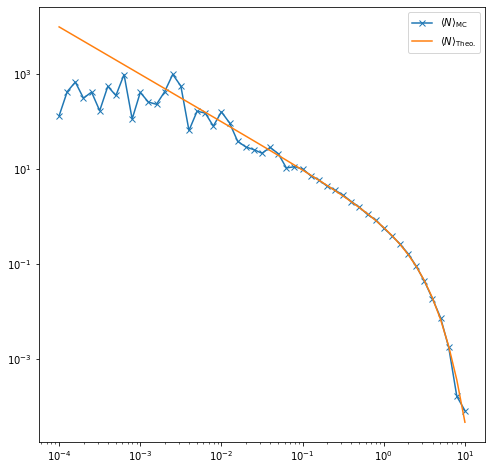

In [128]:
f,ax = plt.subplots(figsize=(8,8))
ax.loglog(be_points, n_avg, marker='x', label=r'$\langle N \rangle_{{\mathrm{{MC}}}}$')
ax.loglog(be_points, n_avg_theo, label=r'$\langle N \rangle_{{\mathrm{{Theo.}}}}$')
ax.legend()

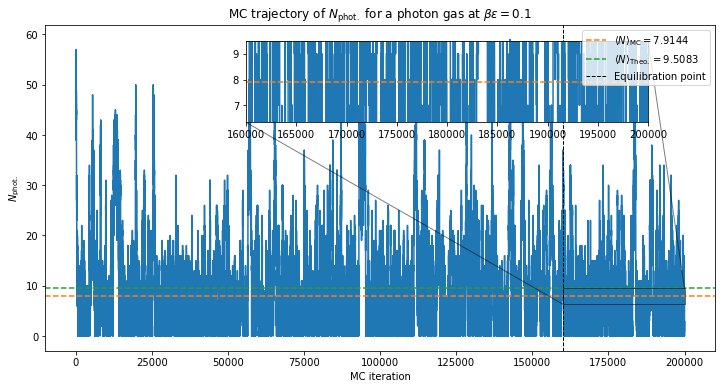

In [105]:
_, ax = a.plot_mc_traj()

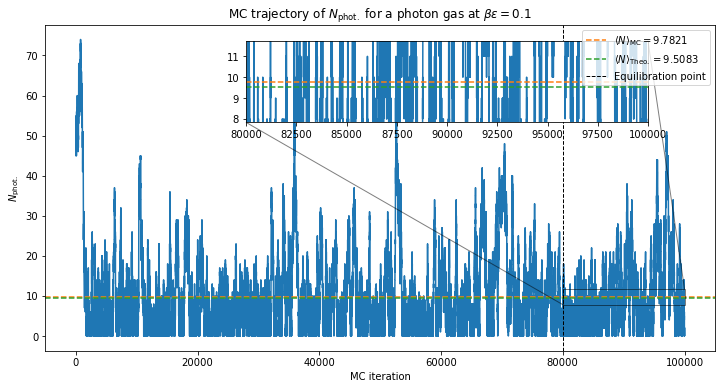

In [99]:
f,ax = plt.subplots(figsize=(12,6))
ax.plot(a.n_traj[:])
ax.axhline(a.mc_avg, linestyle='--', c='tab:orange', label=r'$\langle N \rangle_{{\mathrm{{MC}}}}={mc_avg:.4f}$'.format(mc_avg=a.mc_avg))
ax.axhline(a.theo_avg ,linestyle='--', c='tab:green', label=r'$\langle N \rangle_{{\mathrm{{Theo.}}}}={theo_avg:.4f}$'.format(theo_avg=a.theo_avg))
ax.axvline(a.eqm_steps, linestyle='--', linewidth=1, c='k',label='Equilibration point')
axins = ax.inset_axes([0.3,0.7,0.6,0.25])
axins.plot(a.n_traj[:])
axins.set_xlim([a.eqm_steps,a.n_steps])
axins.axhline(a.mc_avg, linestyle='--', c='tab:orange', label=r'$\langle N \rangle_{{\mathrm{{MC}}}}={mc_avg:.4f}$'.format(mc_avg=a.mc_avg))
axins.axhline(a.theo_avg ,linestyle='--', c='tab:green', label=r'$\langle N \rangle_{{\mathrm{{Theo.}}}}={theo_avg:.4f}$'.format(theo_avg=a.theo_avg))
axins.set_ylim([a.mc_avg*0.8, a.mc_avg*1.2])
#xticklabels = np.arange(a.eqm_steps,a.n_steps,int((a.n_steps-a.eqm_steps)/len(ax.get_xticks()))-1)
#ax.set_xticklabels(xticklabels)
ax.legend()
ax.set_xlabel('MC iteration')
ax.set_ylabel(r'$N_{{\mathrm{{phot.}}}}$')
ax.indicate_inset_zoom(axins, edgecolor="black")
_=ax.set_title(r'MC trajectory of $N_{{\mathrm{{phot.}}}}$ for a photon gas at $\beta\epsilon={i}$'.format(i=a.be))

### Question 3: Answer

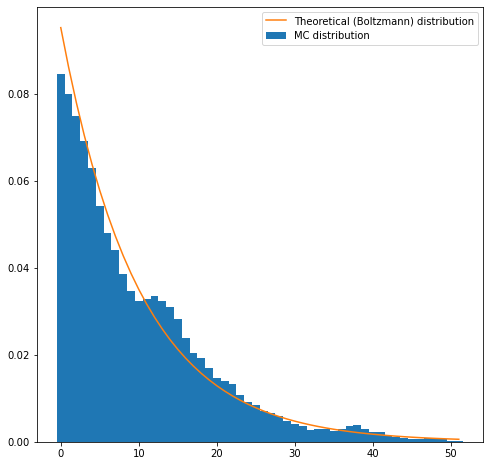

In [100]:
f,ax = plt.subplots(figsize=(8,8))
configs = np.array(sorted(a.configs.keys()))
prob = np.array([a.configs[_] for _ in configs],dtype='float64')
prob /= float(a.n_steps-a.eqm_steps)

theo_points = np.arange(0,configs[-1]+1)
theo_dist = np.array([np.exp(-a.be*_) for _ in theo_points]) * (1-np.exp(-a.be))

ax.bar(configs,prob,width=1,label='MC distribution')
ax.plot(theo_points,theo_dist,c='tab:orange',label='Theoretical (Boltzmann) distribution')
ax.legend()

In [108]:
np.arange(-4,1.1,0.1)

array([-4.00000000e+00, -3.90000000e+00, -3.80000000e+00, -3.70000000e+00,
       -3.60000000e+00, -3.50000000e+00, -3.40000000e+00, -3.30000000e+00,
       -3.20000000e+00, -3.10000000e+00, -3.00000000e+00, -2.90000000e+00,
       -2.80000000e+00, -2.70000000e+00, -2.60000000e+00, -2.50000000e+00,
       -2.40000000e+00, -2.30000000e+00, -2.20000000e+00, -2.10000000e+00,
       -2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
       -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
       -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
       -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
        3.55271368e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01,  9.00000000e-01,  1.00000000e+00])